# Прогноз температуры стали во время плавки 
**Описание проекта:**

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель проекта:** 

Построить модель, которая предскажет температуру стали.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-общей-информации-из-файлов" data-toc-modified-id="Изучение общей-информации-из-файлов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение общей информации из файлов</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Создание-финального-датасета" data-toc-modified-id="Создание-финального-датасета-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание финального датасета</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Отчёт" data-toc-modified-id="Отчёт-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Отчёт</a></span></li></ul></div>

## Изучение общей информации из файлов

Импортируем нужные нам библиотеки

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

sns.set(rc={'figure.figsize':(10, 5)})
pd.options.mode.chained_assignment = None
RANDOM_STATE = 100423

Считаем данные в датафреймы 

In [3]:
try:
    arc = pd.read_csv('final_steel/data_arc.csv')
    bulk = pd.read_csv('final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    gas = pd.read_csv('final_steel/data_gas.csv')
    temp = pd.read_csv('final_steel/data_temp.csv')
    wire = pd.read_csv('final_steel/data_wire.csv')
    wire_time = pd.read_csv('final_steel/data_wire_time.csv')
except:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')


In [4]:
df = {'Данные об электродах': arc, 
      'Данные о подаче сыпучих материалов (объём)' : bulk,
      'Данные о подаче сыпучих материалов (время)' : bulk_time, 
      'Данные о продувке сплава газом' : gas, 
      'Результаты измерения температуры': temp, 
      'Данные о проволочных материалах (объём)': wire, 
      'Данные о проволочных материалах (время)': wire_time}

Выведим первые 5 строчек и последние 5 строчек для каждого датафрейма

In [5]:
for i in df:
    print(i)
    display(df[i])

Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выведем основную информацию о датафреймах

In [6]:
for i in df:
    print(i)
    print(df[i].info())
    print()

Данные об электродах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Данные о подаче сыпучих материалов (объём)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null   

**Вывод:** В данных 3241 партий стали. Дату и время нужно перевести в тип данных `datetime`.

Везде разное количество строк. Эти данные надо как-то объединить, скорее всего через `key`. 

## Исследовательский анализ данных

Посмотрим на пропуски в процентном соотношении

In [7]:
for i in df:
    print(i)
    print('Всего пропусков', df[i].isna().sum().sum())
    display(pd.DataFrame(round(df[i].isna().mean()*100)).style.background_gradient('coolwarm'))
    print()

Данные об электродах
Всего пропусков 0


,0
key,0.000000
Начало нагрева дугой,0.000000
Конец нагрева дугой,0.000000
Активная мощность,0.000000
Реактивная мощность,0.000000



Данные о подаче сыпучих материалов (объём)
Всего пропусков 35776


,0
key,0.000000
Bulk 1,92.000000
Bulk 2,99.000000
Bulk 3,59.000000
Bulk 4,68.000000
Bulk 5,98.000000
Bulk 6,82.000000
Bulk 7,99.000000
Bulk 8,100.000000
Bulk 9,99.000000



Данные о подаче сыпучих материалов (время)
Всего пропусков 35776


,0
key,0.000000
Bulk 1,92.000000
Bulk 2,99.000000
Bulk 3,59.000000
Bulk 4,68.000000
Bulk 5,98.000000
Bulk 6,82.000000
Bulk 7,99.000000
Bulk 8,100.000000
Bulk 9,99.000000



Данные о продувке сплава газом
Всего пропусков 0


,0
key,0.000000
Газ 1,0.000000



Результаты измерения температуры
Всего пропусков 2901


,0
key,0.000000
Время замера,0.000000
Температура,18.000000



Данные о проволочных материалах (объём)
Всего пропусков 23385


,0
key,0.000000
Wire 1,1.000000
Wire 2,65.000000
Wire 3,98.000000
Wire 4,100.000000
Wire 5,100.000000
Wire 6,98.000000
Wire 7,100.000000
Wire 8,99.000000
Wire 9,99.000000



Данные о проволочных материалах (время)
Всего пропусков 23385


,0
key,0.000000
Wire 1,1.000000
Wire 2,65.000000
Wire 3,98.000000
Wire 4,100.000000
Wire 5,100.000000
Wire 6,98.000000
Wire 7,100.000000
Wire 8,99.000000
Wire 9,99.000000


Проверим данные на дубликаты

In [8]:
for i in df:
    print(i)
    print('Количество дубликатов:', df[i].duplicated().sum())
    print()

Данные об электродах
Количество дубликатов: 0

Данные о подаче сыпучих материалов (объём)
Количество дубликатов: 0

Данные о подаче сыпучих материалов (время)
Количество дубликатов: 0

Данные о продувке сплава газом
Количество дубликатов: 0

Результаты измерения температуры
Количество дубликатов: 0

Данные о проволочных материалах (объём)
Количество дубликатов: 0

Данные о проволочных материалах (время)
Количество дубликатов: 0



**Вывод:** В данных о подаче сыпучих и проволочных материалов очень много пропусков. Некоторые колонки и вовсе не используются. 

Дубликатов в данных нет. 

С помощью метода `describe()` посмотрим на основные характеристики.

In [9]:
for i in df:
    print(i)
    display(df[i].describe())
    print()

Данные об электродах


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Данные о подаче сыпучих материалов (время)


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Данные о продувке сплава газом


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Результаты измерения температуры


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Данные о проволочных материалах (время)


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Изучим подробнее выбросы с помощью `boxplot` 

<AxesSubplot:xlabel='Активная мощность'>

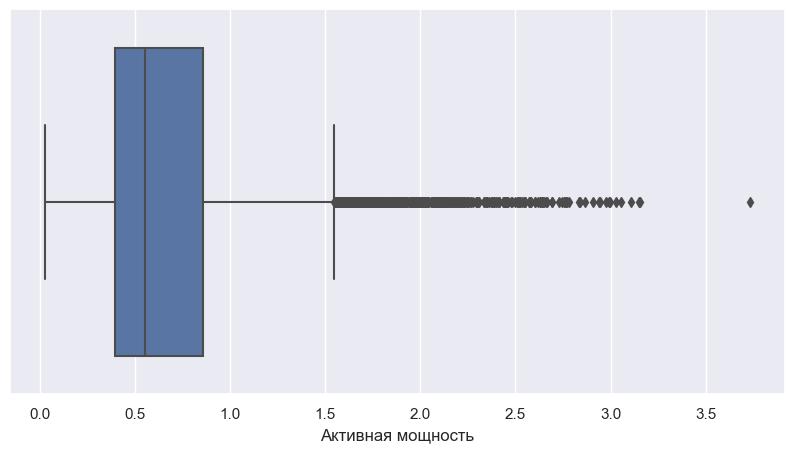

In [10]:
sns.boxplot(x=arc['Активная мощность'])

Нарисуем график распределения 

<AxesSubplot:xlabel='Активная мощность', ylabel='Count'>

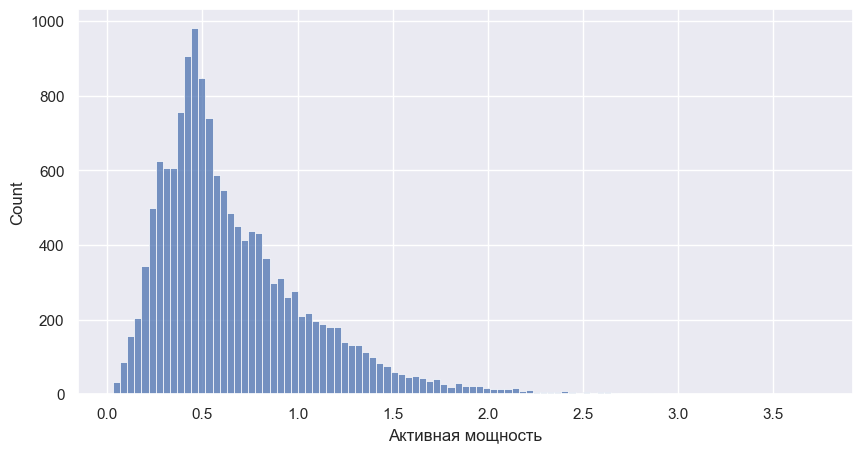

In [11]:
sns.histplot(arc['Активная мощность'])

<AxesSubplot:xlabel='Реактивная мощность'>

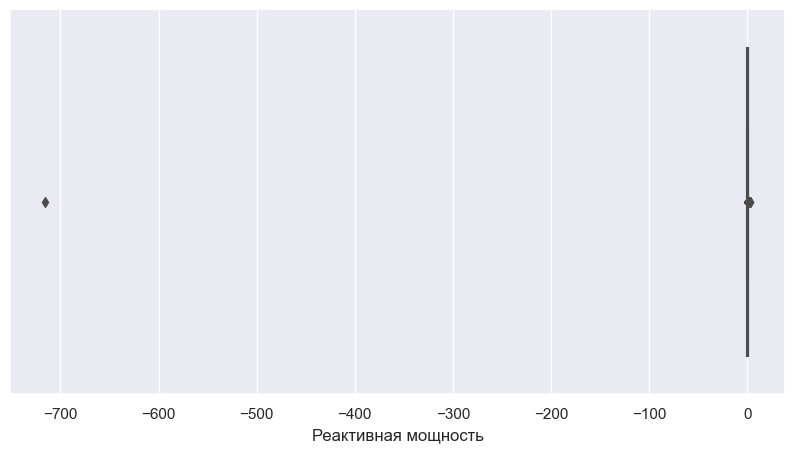

In [12]:
sns.boxplot(x=arc['Реактивная мощность'])

Посмотрим на диаграмму без явного выброса около -700

<AxesSubplot:xlabel='Реактивная мощность'>

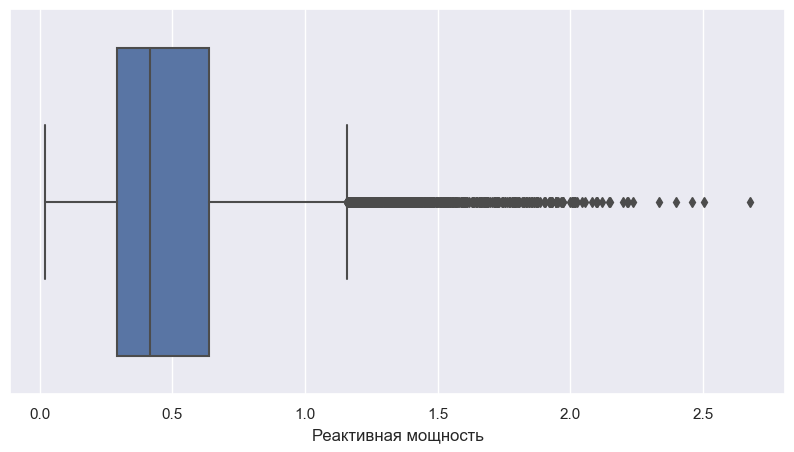

In [13]:
sns.boxplot(x=arc[arc['Реактивная мощность'] > -100]['Реактивная мощность'])

<AxesSubplot:xlabel='Реактивная мощность', ylabel='Count'>

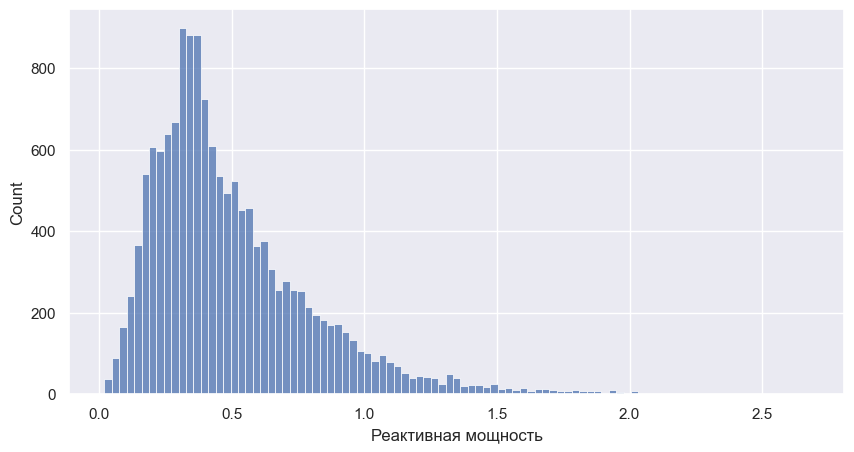

In [14]:
sns.histplot(arc[arc['Реактивная мощность'] > -100]['Реактивная мощность'])

<AxesSubplot:xlabel='Температура'>

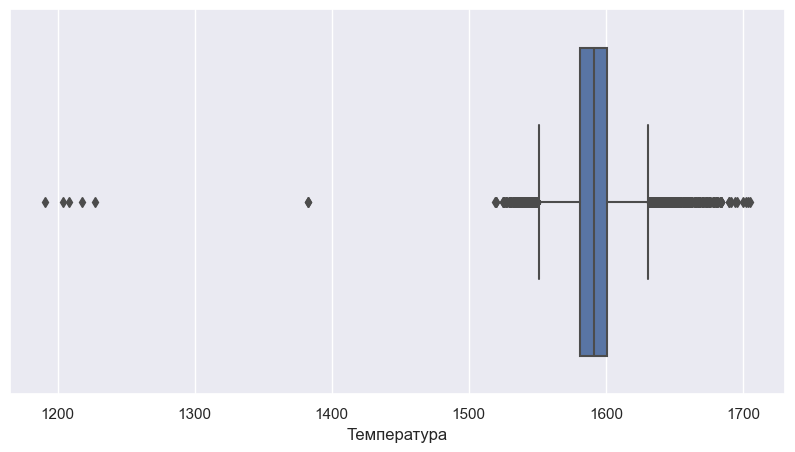

In [15]:
sns.boxplot(x=temp['Температура'])

<AxesSubplot:xlabel='Температура', ylabel='Count'>

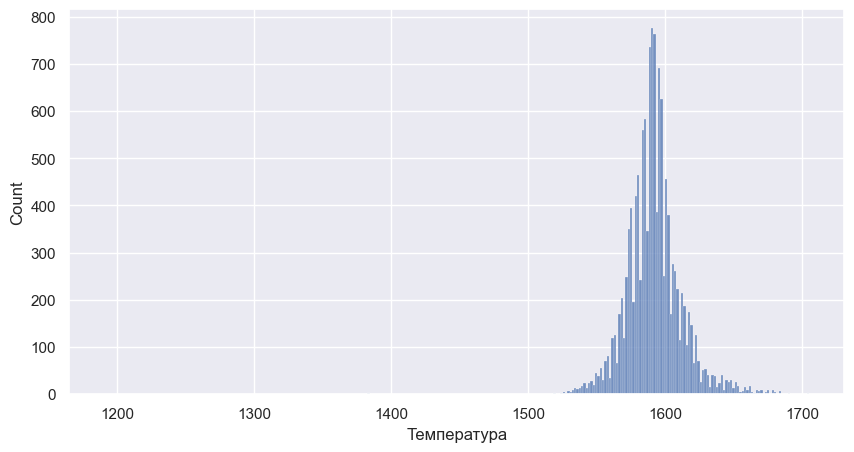

In [16]:
sns.histplot(temp['Температура'])

<AxesSubplot:xlabel='Газ 1'>

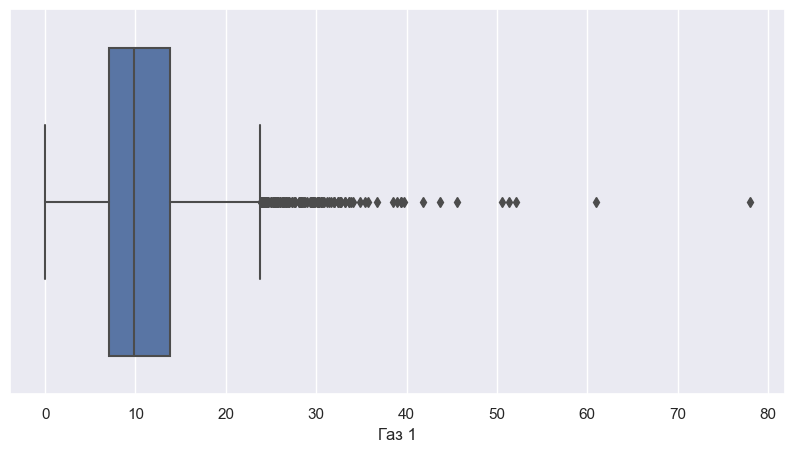

In [17]:
sns.boxplot(x=gas['Газ 1'])

<AxesSubplot:xlabel='Газ 1', ylabel='Count'>

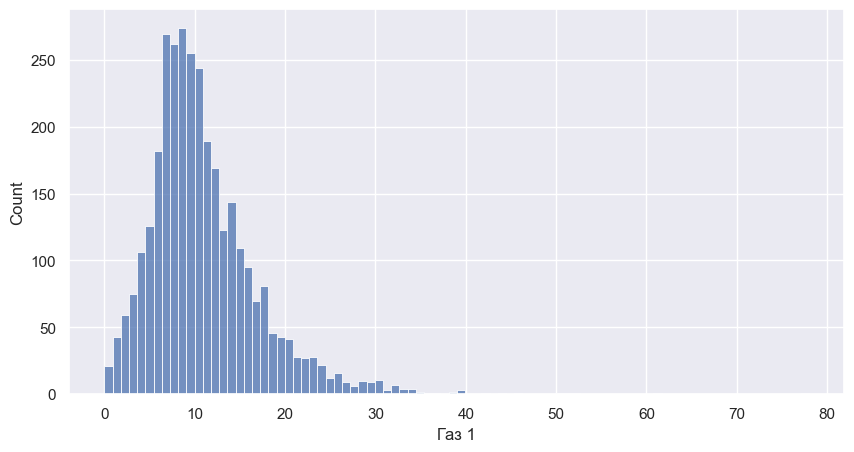

In [18]:
sns.histplot(gas['Газ 1'])

**Вывод:** 
В данных присутствуют выбросы. Распределения похожи на нормальные. 

**Вывод по разделу:**

* Данные нужно будет объединить. 

* Нужна предобработка данных. Пропущенные значения о подаче сыпучих и проволочных материалов нужно заменить на 0. Пропуски в температуре также нужно будет обработать.

* Критичные выбросы убираем. 




## Предобработка данных 

Преобразуем дату и время в тип `datetime`

In [19]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

In [20]:
for i in range(1, 10):
    wire_time[f'Wire {i}'] = pd.to_datetime(wire[f'Wire {i}'])
    
for i in range(1, 16):
    bulk_time[f'Bulk {i}'] = pd.to_datetime(bulk_time[f'Bulk {i}'])

Обработаем пропуски. Пропущенные значения о подаче сыпучих и проволочных материалов значат, что эти материалы не использовали, значит их можно заменить на 0

In [21]:
wire = wire.fillna(0)
wire_time = wire_time.fillna(0)
bulk = bulk.fillna(0)
bulk_time = bulk_time.fillna(0)

Избавимся от выбросов

In [22]:
arc = arc[arc['Реактивная мощность'] > -100]
temp = temp.query("Температура > 1400 | Температура.isna()")

Добавим новый признак - суммарное количество материалов для каждой партии

In [23]:
wire['sum_wire'] = wire.loc[:, 'Wire 1':'Wire 9'].sum(axis=1)
bulk['sum_bulk'] = bulk.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1)

Также найдём полную мощность 

In [24]:
arc['Полная мощность'] = (arc['Активная мощность']**2 + arc['Реактивная мощность']**2)**0.5

## Создание финального датасета

Добавим в финальный датасет наше целевое значение - окончательную температуру партии

In [25]:
final_df = pd.DataFrame()
final_df['last_temp'] = temp.groupby('key')['Температура'].nth(-1)
final_df.reset_index(inplace=True)

Выделим нужные признаки из предыдущих таблиц и соединим с итоговым: 

* Начальную температуру 
* Количество газа
* Время нагрева до окончательной температуры (в секунадах)
* Суммарное количество сыпучих материалов
* Суммарное количество проволочных материалов
* Суммарная полная мощность 

In [26]:
final_df = final_df.merge(temp.groupby('key')['Температура'].nth(0), on='key')
final_df = final_df.merge(gas, on='key')
final_df = final_df.merge((temp.groupby('key')['Время замера'].nth(-1) - temp.groupby('key')['Время замера'].nth(0)).dt.seconds, on='key')
final_df = final_df.merge(wire[['key', 'sum_wire']], on='key')
final_df = final_df.merge(bulk[['key', 'sum_bulk']], on='key')
final_df = final_df.merge(arc.groupby('key')['Полная мощность'].sum(), on='key')

In [27]:
final_df = final_df.rename(columns = {'Температура': 'first_temp', 'Газ 1': 'gas', 
                                      'Полная мощность': 'sum_full_power', 'Время замера' : 'heating_time'})

In [28]:
final_df.tail(10)

,key,last_temp,first_temp,gas,heating_time,sum_wire,sum_bulk,sum_full_power
3012,3232,NaN,1563.0,8.630453,1279,15.069600,570.0,3.730463
3013,3233,NaN,1597.0,7.366606,1390,107.147033,572.0,2.019433
3014,3234,NaN,1614.0,9.110702,1271,110.160957,466.0,1.477229
3015,3235,NaN,1590.0,5.710729,1718,125.099525,528.0,3.049125
3016,3236,NaN,1607.0,6.958647,1409,101.162880,640.0,1.313892
3017,3237,NaN,1569.0,5.543905,1299,38.088959,758.0,4.844982
3018,3238,NaN,1584.0,6.745669,749,56.128799,594.0,2.696542
3019,3239,NaN,1598.0,16.023518,3148,143.357761,630.0,5.611883
3020,3240,NaN,1617.0,11.863103,3375,34.070400,272.0,3.891856
3021,3241,NaN,1586.0,12.680959,2078,63.117595,232.0,2.999516


In [29]:
final_df.isna().sum()

key                 0
last_temp         693
first_temp          1
gas                 0
heating_time        0
sum_wire            0
sum_bulk            0
sum_full_power      0
dtype: int64

В целевом присутствуют пропущенные значения (и один в first_temp). Их нужно удалить

In [30]:
final_df = final_df.dropna()

In [31]:
final_df

,key,last_temp,first_temp,gas,heating_time,sum_wire,sum_bulk,sum_full_power
0,1,1613.0,1571.0,29.749986,861,60.059998,553.0,5.826395
1,2,1602.0,1581.0,12.555561,1305,96.052315,582.0,3.649216
2,3,1599.0,1596.0,28.554793,1300,91.160157,544.0,2.989534
3,4,1625.0,1601.0,18.841219,388,89.063515,595.0,3.814962
4,5,1602.0,1576.0,5.413692,762,98.352796,584.0,4.035758
...,...,...,...,...,...,...,...,...
2324,2495,1591.0,1570.0,7.125735,1137,89.150879,719.0,3.986869
2325,2496,1591.0,1554.0,9.412616,1618,114.179527,796.0,5.057033
2326,2497,1589.0,1571.0,6.271699,717,103.134723,665.0,2.885017
2327,2498,1594.0,1591.0,14.953657,1302,118.110717,733.0,4.143749


Посмотрим на окончательную таблицу

In [33]:
final_df.tail(10)

,key,last_temp,first_temp,gas,heating_time,sum_wire,sum_bulk,sum_full_power
2319,2489,1579.0,1613.0,10.772628,1951,67.136162,480.0,1.430227
2320,2490,1619.0,1602.0,20.019526,1917,126.060486,885.0,5.219026
2321,2492,1595.0,1618.0,11.375063,2283,170.046235,945.0,3.220457
2322,2493,1594.0,1599.0,9.421691,1292,122.172958,779.0,2.115727
2323,2494,1591.0,1585.0,3.983053,626,75.042236,591.0,3.054613
2324,2495,1591.0,1570.0,7.125735,1137,89.150879,719.0,3.986869
2325,2496,1591.0,1554.0,9.412616,1618,114.179527,796.0,5.057033
2326,2497,1589.0,1571.0,6.271699,717,103.134723,665.0,2.885017
2327,2498,1594.0,1591.0,14.953657,1302,118.110717,733.0,4.143749
2328,2499,1603.0,1569.0,11.336151,1203,160.166238,633.0,4.953010


Проверим данные на мультиколлинеарность

In [34]:
final_df.corr()

,key,last_temp,first_temp,gas,heating_time,sum_wire,sum_bulk,sum_full_power
key,1.000000,-0.097242,-0.015911,-0.043486,-0.002515,0.002886,-0.026203,-0.015447
last_temp,-0.097242,1.000000,0.301320,0.059160,0.097475,0.061061,0.222658,0.273558
first_temp,-0.015911,0.301320,1.000000,0.036047,0.208995,0.131562,-0.112063,-0.429306
gas,-0.043486,0.059160,0.036047,1.000000,0.454414,0.215411,0.314006,0.370528
heating_time,-0.002515,0.097475,0.208995,0.454414,1.000000,0.216703,0.319692,0.543310
sum_wire,0.002886,0.061061,0.131562,0.215411,0.216703,1.000000,0.007119,0.082486
sum_bulk,-0.026203,0.222658,-0.112063,0.314006,0.319692,0.007119,1.000000,0.559714
sum_full_power,-0.015447,0.273558,-0.429306,0.370528,0.543310,0.082486,0.559714,1.000000


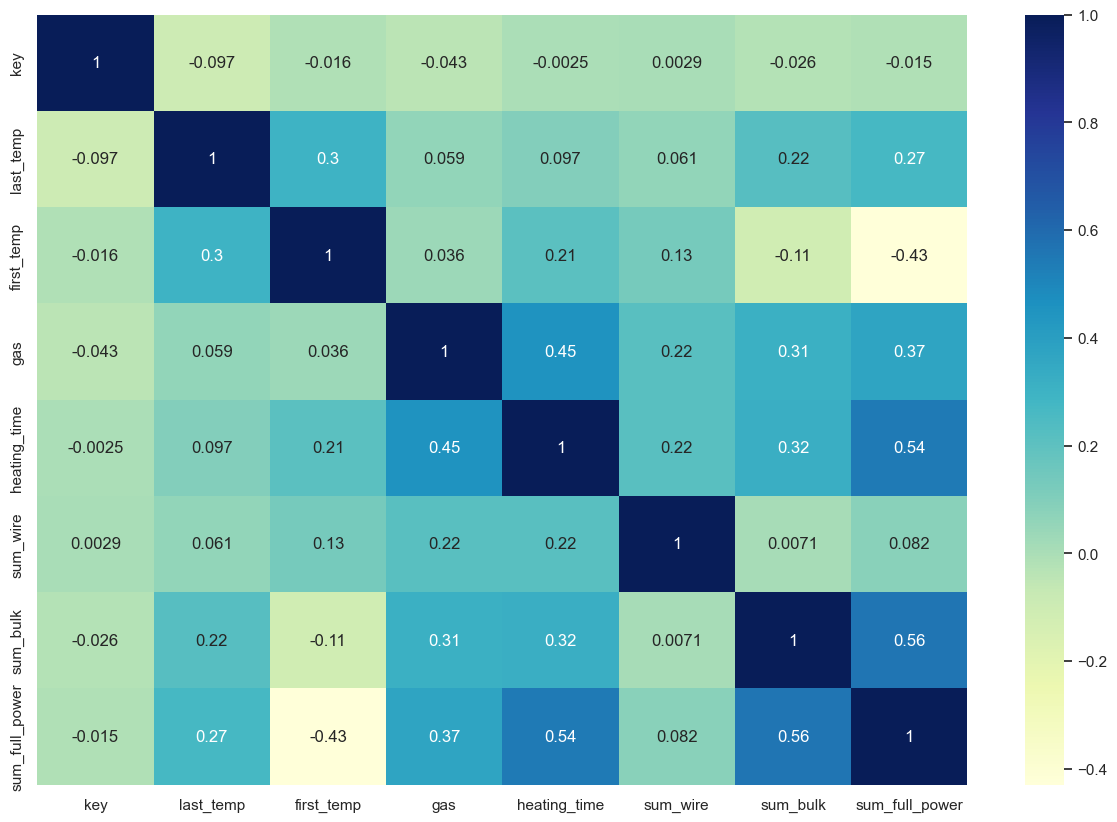

In [35]:
plt.subplots(figsize=(15, 10))        
sns.heatmap(final_df.corr(), cmap="YlGnBu", annot=True)  
plt.show()

**Вывод:** Сильной корреляции между признаками не обнаружено

Разделим данные на обучающую и тестовую выборки

In [36]:
target = final_df['last_temp']
features = final_df.drop(['last_temp','key'], axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            random_state=RANDOM_STATE, test_size=0.25)

## Обучение моделей

Обучим модели линейной регрессии, случайного леса и CatBoost, проверим их качество на кросс-валидации, найдём лучшие параметры с помощью `RandomizedSearchCV`

**Линейная регрессия**

In [37]:
lr_model = LinearRegression() 
lr_model.fit(features_train, target_train)
scores = (-1) * cross_val_score(lr_model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error') 
lr_final_score = scores.mean()
print('Качество модели линейной регрессии MAE:', lr_final_score)

Качество модели линейной регрессии MAE: 6.273438676923474


**Случайный лес**

In [38]:
%%time

model = RandomForestRegressor(random_state=RANDOM_STATE) 
parametrs = { 'n_estimators': range (1, 50),
              'max_depth': range (1, 50)
            }            
            
rf_model = RandomizedSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error')
rf_model.fit(features_train, target_train)

Wall time: 4.07 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100423),
                   param_distributions={'max_depth': range(1, 50),
                                        'n_estimators': range(1, 50)},
                   scoring='neg_mean_absolute_error')

In [39]:
print('Качество модели случайного леса MAE:', -rf_model.cv_results_["mean_test_score"][0])
print('Лучшие параметры:', rf_model.best_params_)

Качество модели случайного леса MAE: 6.289073821080824
Лучшие параметры: {'n_estimators': 31, 'max_depth': 10}


**CatBoost**

In [40]:
%%time

model = CatBoostRegressor(random_state=RANDOM_STATE) 
parametrs = { 
              'learning_rate': [0.01, 0.1],
              'max_depth': range (1, 10)
            }            
            
cat_model = RandomizedSearchCV(model, parametrs, cv=5, scoring='neg_mean_absolute_error')
cat_model.fit(features_train, target_train)

0:	learn: 11.2822022	total: 177ms	remaining: 2m 56s
1:	learn: 11.2542159	total: 181ms	remaining: 1m 30s
2:	learn: 11.2228035	total: 185ms	remaining: 1m 1s
3:	learn: 11.1946837	total: 190ms	remaining: 47.3s
4:	learn: 11.1669502	total: 194ms	remaining: 38.6s
5:	learn: 11.1385291	total: 198ms	remaining: 32.8s
6:	learn: 11.1096261	total: 202ms	remaining: 28.7s
7:	learn: 11.0786925	total: 207ms	remaining: 25.6s
8:	learn: 11.0519055	total: 211ms	remaining: 23.2s
9:	learn: 11.0231067	total: 215ms	remaining: 21.3s
10:	learn: 10.9976228	total: 219ms	remaining: 19.7s
11:	learn: 10.9689382	total: 223ms	remaining: 18.4s
12:	learn: 10.9420512	total: 227ms	remaining: 17.2s
13:	learn: 10.9131658	total: 231ms	remaining: 16.2s
14:	learn: 10.8849697	total: 235ms	remaining: 15.4s
15:	learn: 10.8627375	total: 239ms	remaining: 14.7s
16:	learn: 10.8380069	total: 242ms	remaining: 14s
17:	learn: 10.8092372	total: 246ms	remaining: 13.4s
18:	learn: 10.7869003	total: 250ms	remaining: 12.9s
19:	learn: 10.7662910	

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001E96CFF2E80>,
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': range(1, 10)},
                   scoring='neg_mean_absolute_error')

In [41]:
print('Качество модели CatBoost MAE:', -cat_model.cv_results_["mean_test_score"][0])
print('Лучшие параметры:', cat_model.best_params_)

Качество модели CatBoost MAE: 6.14680321280147
Лучшие параметры: {'max_depth': 7, 'learning_rate': 0.01}


Сравним результаты моделей

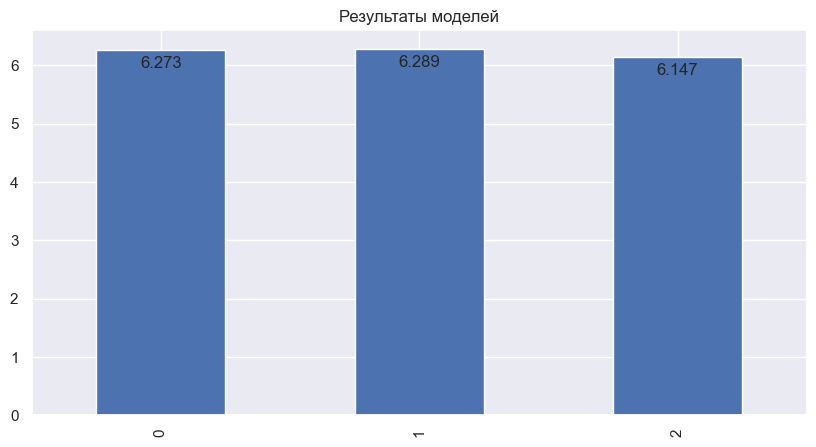

In [42]:
import matplotlib.pyplot as plt
models = pd.DataFrame({'Модели': ['Линейная регрессия', 'Случайный лес', 'CatBoost'],
    'Качество': [lr_final_score, -rf_model.cv_results_["mean_test_score"][0], -cat_model.cv_results_["mean_test_score"][0]]})

#ax = models.plot.bar(x='Модели', y='Качество', legend=False)
#ax.bar_label(ax.containers[0])

ax = models.plot.bar(title="Результаты моделей", legend=False, figsize=(10, 5))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, -10), textcoords='offset points')

**Вывод:** CatBoost показала лучший результат на кросс-валидации MAE = 6.152103860843562. 

## Тестирование модели

Проверим качество этой модели на тестовой выборке

In [43]:
pred_test = cat_model.predict(features_test) 
result = mean_absolute_error(target_test, pred_test)
print('Качество модели на тестовой выборке CatBoost MAE:', result)

Качество модели на тестовой выборке CatBoost MAE: 6.176239482002186


**Анализ важности факторов**

In [44]:
feature_importance = pd.Series(cat_model.best_estimator_.get_feature_importance(),
                         final_df.drop(['last_temp', 'key'], axis=1).columns)

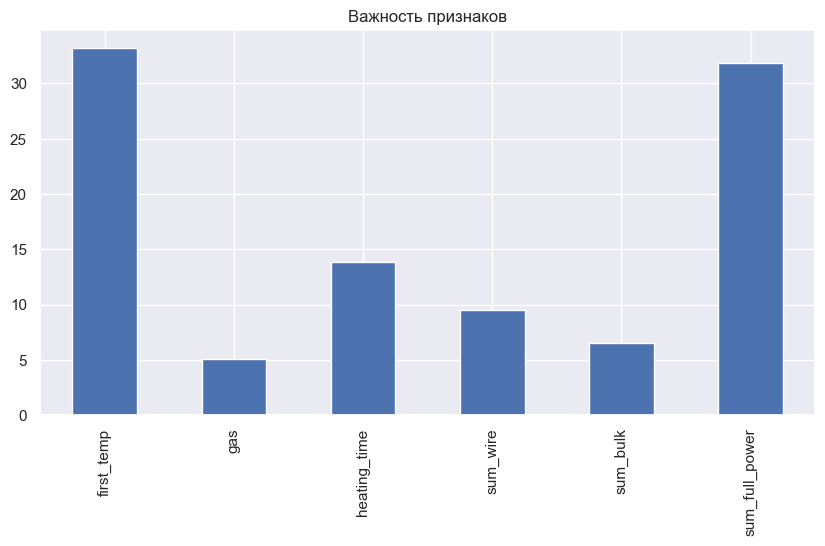

In [45]:
feature_importance.plot(kind='bar',figsize=(10, 5))
plt.title('Важность признаков')
plt.show()

**Вывод:** Наиболее важными факторами оказались начальная температура и полная мощность. 

## Отчёт


**1. Итоговая модель и её качество**

Итоговая модель `CatBoost` с MAE = 6.176239482002186

**2. Список признаков, используемых для обучения лучшей модели и описание их предобработки**
 
* Начальная температура. Из таблицы результатов измерения температуры для каждой партии бралось начальное значение. 
* Количество газа. Из данных о продувке сплава газом для каждого значения газа была одна партия. 
* Время нагрева до окончательной температуры (в секунадах). Из таблицы результатов измерения температуры бралось изменение времени измерения последней темепературы для партии и начальной. 
* Суммарное количество сыпучих материалов. Из данных о сыпучих материалах бралась сумма каждого материала для каждой партии. Пропущенные значения были заменены на 0. 
* Суммарное количество проволочных материалов. Из данных о проволочных материалах бралась сумма каждого материала для каждой партии. Пропущенные значения были заменены на 0.
* Суммарная полная мощность. Из данных об электродах вычислялась полная мощность для каждой строчки , а затем складывалась общая полная мощность для партии

**3. Гиперпараметры лучшей модели, включая random_state (если имеется у модели)**

`max_depth` = 7, `learning_rate` = 0.01 `random_state` = 10042023